### Definimos las constantes y modulos implicados en nuestro proyecto:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from re import sub

pd.set_option('display.max_rows', 10) #sin límite
pd.set_option('display.max_columns', 20)


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import TimeoutException

from bs4 import BeautifulSoup 

from time import time, sleep
from datetime import date

from pymongo import MongoClient

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order


import requests 

import geopandas as gp 

In [4]:
#definimos constantes fundamentales
url = "https://eportal.miteco.gob.es/BoleHWeb/"
uri = "mongodb://localhost:27017" #string de conexión a mi base de datos mongo

anos = [str(ano) for ano in range(2005,2023)]
meses = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
meses_30 =["Abril" , "Junio", "Septiembre", "Noviembre"]
cols = ["Embalse", "Río", "capacidad", "Agua actual", "+/- semana anterior", "Energía disponible", "Energía actual"] #unidad: hm^3 de capacidad, 
dtypes = {'Embalse':'str','Río':'str', 'capacidad':'int32','Agua actual':'int32','+/- semana anterior':'int32',
                             'Energía disponible':'int32', 'Energía actual':'int32'}

dias_31 = [1,8,15,22,31]
dias_30 = [1,8,15,22,30]
dias_29 = [1,8,15,22,29]
dias_28 = [1,8,15,22,28]

mes_num = {"Enero":1, "Febrero":2, "Marzo":3, "Abril":4, "Mayo":5, "Junio":6, 
           "Julio":7, "Agosto":8, "Septiembre":9, "Octubre":10, "Noviembre":11, "Diciembre":12}

client = MongoClient(uri)


In [22]:
def ext_tablas(soup, start=0, end=-1): 
    #convierte tablas html en listas de listas
    filas= soup.find_all("tr")[start:end]
    result= []
    for fila in filas:
        vals = [val for val in fila.stripped_strings]
        result.append(vals)
    result = [fil for fil in result if fil != []] 
    return result

class tiempo:
    def __init__(self, time):
        def conversor_time(time):
            #convierte cantidades medidas en segundos por cantidad de horas, minutos, segundos
            horas = time  //  3600
            minutos = time % 3600 // 60
            segundos = time % 3600 % 60
            return (horas, minutos, segundos)
        convertido = conversor_time(time)
        self.hrs = convertido[0]
        self.mins = convertido[1]
        self.secs = convertido[2]
    def __str__(self):
        return f"Un lapso de {self.hrs} horas, {self.mins} minutos y {self.secs} segundos"
    pass
        
    
    
def conversor_time(time):
    #convierte cantidades medidas en segundos por cantidad de horas, minutos, segundos
    horas = time  //  3600
    minutos = time % 3600 // 60
    segundos = time % 3600 % 60
    return hms(horas, minutos, segundos)

### Volcamos los datos de embalses del ministerio de medio ambiente sobre una base de datos de MongoDB

In [ ]:
wait_time = 0
t0 = time() #hora de inicio
driver = webdriver.Chrome()
driver.set_window_size(1920, 1080)
for ano_act in anos:
    for mes_act in meses:
        if mes_act in meses_30: #el mes tiene 30 días
            semanas = dias_30
        elif mes_act == "Febrero": #el mes es Febrero
            if int(ano_act) % 4 == 0: #Febrero de año bisiesto, 29 días
                semanas = dias_29
            else: #febrero de año ordinario, 28 días
                semanas = dias_28
        else: #mes de 31 días
            semanas = dias_31
        for dia in semanas:
            try:
                sleep(wait_time) #esperamos el tiempo necesario para que no nos penalice el servidor. En un principio no lo haremos.
                driver.get(url)
                ano = driver.find_element(By.xPATH, "//select[@id='year']")
                mes= driver.find_element(By.xPATH, "//select[@id='month']")
                Select(ano).select_by_visible_text(ano_act)
                Select(mes).select_by_visible_text(mes_act)
                driver.find_elements(By.xPATH, "//button[@class = 'calendario']")[dia-1].click() #clicamos el boton del calendario
                driver.find_element(By.xPATH, "//button[@id='btnMnuReserva']").click() #accedemos a reservas
                driver.find_element(By.xPATH, "//button[@id='btnMod_Reserva_Hidraulica_Datos_5']").click() #clicamos en la cuenca del guadalquivir
                tabla = driver.find_element(By.xPATH, "//tbody[descendant::*[text()='Embalses']]" ) #llegamos a la tabla
                soup = BeautifulSoup(tabla.get_attribute("outerHTML"), 'html.parser') #parseamos el html de la tabla
                data = ext_tablas(soup, start= 2) #creamos una lista de listas con la tabla
                data = pd.DataFrame(data, columns = cols) #transformamos la lista de listas en un pandas.DataFrame
                dat_dict = data.to_dict(orient = 'records') #pasamos el DataFrame a lista de diccionarios
                collection_string = f"{ano_act}-{mes_num[mes_act]}-{dia}" #creamos el nombre de la colección 
                client.embalses[collection_string].insert_many(dat_dict) #exportamos la lista diccionarios a una colección mongoDB
            except TimeoutException: 
                wait_time += 5 # si el navegador se ralentiza demasiado, aumentamos el tiempo de espera
            
            
tf = time() #hora de finalizacion
exe_time_secs = tf -t0 #tiempo de ejecución en segundos
datasize_b = client.embalses.command('dbstats')['dataSize']  #tamaño de la base de datos, en bytes
datasize_gb = datasize_b/(1024^3) #tamaño de la base de datos, en GigaBytes
vel_descarga = datasize_gb/exe_time_secs #velocidad de descarga del programa, en GB/s
num_colls =  client.embalses.command('dbstats')['collections'] #numero de colecciones
to_insert = {"velocidad de descarga":vel_descarga, 'tamaño de la database (GB)':datasize_gb, 'tiempo de ejecución':exe_time_secs,
            'tamaño':num_colls} #documento a insertar
client.embalses.metadatos.insert_one(to_insert) 
driver.quit()


In [58]:
#hallar la velocidad de descarga de la database
print('datos de ejecución de la descarga de datos de embalse')
print ( list(client.embalses.metadatos.find({},{'_id':0}) ) )
exe_time =list( client.embalses.metadatos.find({},{'tiempo de ejecución':1,  '_id':0}) )[0]['tiempo de ejecución']
cronometro = tiempo(exe_time)

print(cronometro)

datos de ejecución de la descarga de datos de embalse
[{'velocidad de descarga': 1.9490608321404714e-06, 'tamaño de la database (GB)': 0.009216437116265297, 'tiempo de ejecución': 4728.655444860458, 'tamaño': 1080}]
Un lapso de 1.0 horas, 18.0 minutos y 48.655444860458374 segundos


### Importamos los datos pluviométricos de manera similar a como hemos procedido con los datos de capacidad de embalses

In [ ]:
wait_time = 0
t0 = time() #hora de inicio
driver = webdriver.Chrome()
driver.set_window_size(1920, 1080)
for ano_act in anos:
    for mes_act in meses:
        if mes_act in meses_30: #el mes tiene 30 días
            semanas = dias_30
        elif mes_act == "Febrero": #el mes es Febrero
            if int(ano_act) % 4 == 0: #Febrero de año bisiesto, 29 días
                semanas = dias_29
            else: #febrero de año ordinario, 28 días
                semanas = dias_28
        else: #mes de 31 días
            semanas = dias_31
        for dia in semanas:
            try:
                sleep(wait_time) #esperamos el tiempo necesario para que no nos penalice el servidor. En un principio no lo haremos.
                driver.get(url)
                ano = driver.find_element(By.xPATH, "//select[@id='year']")
                mes= driver.find_element(By.xPATH, "//select[@id='month']")
                Select(ano).select_by_visible_text(ano_act)
                Select(mes).select_by_visible_text(mes_act)
                driver.find_elements(By.xPATH, "//button[@class = 'calendario']")[dia-1].click() #clicamos el boton del calendario
                driver.find_element(By.xPATH, "//button[@id='btnMnuInformacionPluviometrica']").click() #accedemos a info pluviométrica
                driver.find_element(By.xPATH, "//button[@id='btnMod_Informacion_Pluviometrica_Datos']").click() #solicitamos datos pluviométicos
                fila  = driver.find_element(By.xPATH, "//*[@id='contenido']/table[4]/tbody/tr[3]/td/table/tbody/tr[8]/td[2]" ) #seleccionamos la fila de la tabla con el dato que deseamos
                valor = sub(r'[^0-9,]',"",fila.text)
                valor = valor.replace(",",".")
                valor = float(valor)
                document_string = f"{ano_act}-{mes_num[mes_act]}-{dia}" #creamos el nombre de el documento 
                to_insert = {'fecha':document_string, 'lluvias (mm)':valor}
                client.pluviometro.guadalquivir.insert_one(to_insert) #exportamos el documento a una colección MongoDBDB
            except TimeoutException: 
                wait_time += 5 # si el navegador se ralentiza demasiado, aumentamos el tiempo de espera
            
            
tf = time() #hora de finalizacion
exe_time_secs = tf -t0 #tiempo de ejecución en segundos
datasize_b = client.pluviometro.command('dbstats')['dataSize']  #tamaño de la base de datos, en bytes
datasize_gb = datasize_b/(1024**3) #tamaño de la base de datos, en GigaBytes
vel_descarga = datasize_gb/exe_time_secs #velocidad de descarga del programa, en GB/s
num_docs =  client.pluviometro.command('dbstats')['objects'] #numero de documentos
to_insert = {"velocidad de descarga":vel_descarga, 'tamaño de la database (GB)':datasize_gb, 'tiempo de ejecución':exe_time_secs,
            'tamaño':num_colls, 'cuenca':'Guadalquivir'} #documento a insertar
client.pluviometro.metadatos.insert_one(to_insert) 
driver.quit()

In [61]:
#hallar la velocidad de descarga de la database
print('datos de ejecución de la descarga de datos pluviométricos')

print ( list(client.pluviometro.metadatos.find({},{'_id':0}) ) )
exe_time =list( client.pluviometro.metadatos.find({},{'tiempo de ejecución':1,  '_id':0}) )[0]['tiempo de ejecución']
cronometro = tiempo(exe_time)
print(cronometro)

datos de ejecución de la descarga de datos pluviométricos
[{'tamaño': 1078, 'tamaño de la database (GB)': 0.009216437116265297, 'tiempo de ejecución': 4728.655444860458, 'velocidad de descarga': 1.9490608321404714e-06}]
Un lapso de 1.0 horas, 18.0 minutos y 48.655444860458374 segundos


### Empezamos a dar tratamiento a los datos de la muestra

In [5]:
fechas =  client.embalses.list_collection_names()
fechas.remove('metadatos')
fecha_informes_date = pd.to_datetime(fechas)
fecha_informes_date = sorted (fecha_informes_date)
fecha_informes = [ str(fecha)[0:10].replace('-0','-') for fecha in fecha_informes_date]
fecha_informes

['2005-1-1',
 '2005-1-8',
 '2005-1-15',
 '2005-1-22',
 '2005-1-31',
 '2005-2-1',
 '2005-2-8',
 '2005-2-15',
 '2005-2-22',
 '2005-2-28',
 '2005-3-1',
 '2005-3-8',
 '2005-3-15',
 '2005-3-22',
 '2005-3-31',
 '2005-4-1',
 '2005-4-8',
 '2005-4-15',
 '2005-4-22',
 '2005-4-30',
 '2005-5-1',
 '2005-5-8',
 '2005-5-15',
 '2005-5-22',
 '2005-5-31',
 '2005-6-1',
 '2005-6-8',
 '2005-6-15',
 '2005-6-22',
 '2005-6-30',
 '2005-7-1',
 '2005-7-8',
 '2005-7-15',
 '2005-7-22',
 '2005-7-31',
 '2005-8-1',
 '2005-8-8',
 '2005-8-15',
 '2005-8-22',
 '2005-8-31',
 '2005-9-1',
 '2005-9-8',
 '2005-9-15',
 '2005-9-22',
 '2005-9-30',
 '2005-10-1',
 '2005-10-8',
 '2005-10-15',
 '2005-10-22',
 '2005-10-31',
 '2005-11-1',
 '2005-11-8',
 '2005-11-15',
 '2005-11-22',
 '2005-11-30',
 '2005-12-1',
 '2005-12-8',
 '2005-12-15',
 '2005-12-22',
 '2005-12-31',
 '2006-1-1',
 '2006-1-8',
 '2006-1-15',
 '2006-1-22',
 '2006-1-31',
 '2006-2-1',
 '2006-2-8',
 '2006-2-15',
 '2006-2-22',
 '2006-2-28',
 '2006-3-1',
 '2006-3-8',
 '2006-

In [6]:
emb = {}

for fecha in fecha_informes:
        informe = list ( client.embalses[fecha].find({} ) )
        informe = pd.DataFrame (informe, columns= cols)
        informe = informe.astype( dtypes)
        suma = informe['Agua actual'].sum() #sumamos las capacidades de los embalses de la muestra
        emb[fecha]=suma
emb


{'2005-1-1': 4893,
 '2005-1-8': 4888,
 '2005-1-15': 4874,
 '2005-1-22': 4873,
 '2005-1-31': 4865,
 '2005-2-1': 4863,
 '2005-2-8': 4857,
 '2005-2-15': 4847,
 '2005-2-22': 4814,
 '2005-2-28': 4814,
 '2005-3-1': 4814,
 '2005-3-8': 4821,
 '2005-3-15': 4820,
 '2005-3-22': 4805,
 '2005-3-31': 4788,
 '2005-4-1': 4788,
 '2005-4-8': 4759,
 '2005-4-15': 4720,
 '2005-4-22': 4652,
 '2005-4-30': 4584,
 '2005-5-1': 4584,
 '2005-5-8': 4494,
 '2005-5-15': 4394,
 '2005-5-22': 4328,
 '2005-5-31': 4138,
 '2005-6-1': 4138,
 '2005-6-8': 4040,
 '2005-6-15': 3929,
 '2005-6-22': 3809,
 '2005-6-30': 3697,
 '2005-7-1': 3697,
 '2005-7-8': 3589,
 '2005-7-15': 3473,
 '2005-7-22': 3346,
 '2005-7-31': 3232,
 '2005-8-1': 3232,
 '2005-8-8': 3115,
 '2005-8-15': 3016,
 '2005-8-22': 2920,
 '2005-8-31': 2738,
 '2005-9-1': 2738,
 '2005-9-8': 2672,
 '2005-9-15': 2683,
 '2005-9-22': 2667,
 '2005-9-30': 2642,
 '2005-10-1': 2642,
 '2005-10-8': 2627,
 '2005-10-15': 2638,
 '2005-10-22': 2637,
 '2005-10-31': 2640,
 '2005-11-1': 2

In [11]:
pluvs.to_csv("C:/Users/Administrador/Documents/data_science/datos y codigo master/pluvs(embalses).csv")
caps.to_csv("C:/Users/Administrador/Documents/data_science/datos y codigo master/caps(embalses).csv")

([<matplotlib.axis.XTick at 0x1cc5d381d50>,
 [Text(0, 0, '2005-1-1'),
  Text(200, 0, '2008-5-1'),
  Text(400, 0, '2011-9-1'),
  Text(600, 0, '2015-1-1'),
  Text(800, 0, '2018-5-1'),
  Text(1000, 0, '2021-9-1')])

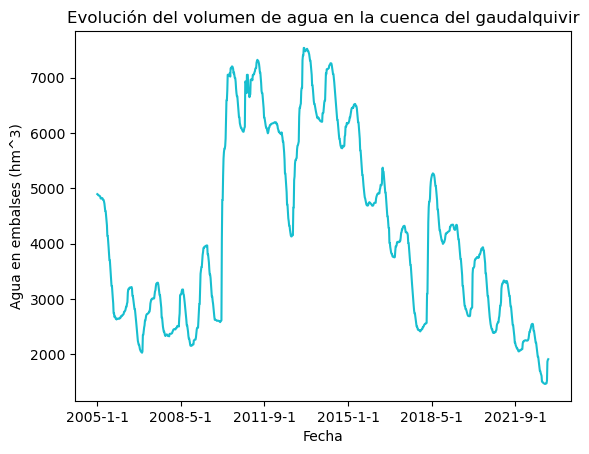

In [7]:
caps = pd.Series(emb)

x = [i for i in range(len(caps))]
y = caps.values

plt.subplots()
plt.plot(x,y, color = "C9")
plt.title('Evolución del volumen de agua en la cuenca del gaudalquivir')
plt.xlabel('Fecha')
plt.ylabel('Agua en embalses (hm^3)')

xlabels = list(emb.keys())[::200]
xticks = range(0,len(emb),200)
plt.xticks(xticks, xlabels)



Ahora graficamos las precipitaciones

In [8]:
lista_entradas = [ entrada for entrada in client.pluviometro.guadalquivir.find({},{'_id':0}) ]
pluv = { entrada['fecha']:entrada['lluvias (mm)'] for entrada in lista_entradas }
pluvs = pd.Series(pluv)


In [34]:
pluvs

2005-1-1        0.2
2005-1-8        0.0
2005-1-15       0.0
2005-1-22       0.0
2005-1-31       0.0
2005-2-1        4.7
2005-2-8        2.1
2005-2-15       0.0
2005-2-22      26.4
2005-2-28      26.4
2005-3-1       33.3
2005-3-8        3.4
2005-3-15       0.0
2005-3-22       5.7
2005-3-31       3.4
2005-4-1        3.4
2005-4-8        8.0
2005-4-15       0.0
2005-4-22       0.0
2005-4-30       0.2
2005-5-1        0.2
2005-5-8        1.0
2005-5-15      17.7
2005-5-22       1.5
2005-5-31       1.6
2005-6-1        1.6
2005-6-8        0.1
2005-6-15       0.0
2005-6-22       0.1
2005-6-30       0.0
2005-7-1        0.0
2005-7-8        0.0
2005-7-15       0.0
2005-7-22       0.0
2005-7-31       0.0
2005-8-1        0.0
2005-8-8        0.0
2005-8-15       0.0
2005-8-22       0.0
2005-8-31       0.0
2005-9-1        0.0
2005-9-8       11.9
2005-9-15       0.8
2005-9-22       0.0
2005-9-30       3.5
2005-10-1       3.5
2005-10-8       2.0
2005-10-15     68.6
2005-10-22     15.2
2005-10-31      9.2


([<matplotlib.axis.XTick at 0x2689cbe2510>,
 [Text(0, 0, '2005-1-1'),
  Text(200, 0, '2008-5-1'),
  Text(400, 0, '2011-9-8'),
  Text(600, 0, '2015-1-8'),
  Text(800, 0, '2018-5-8'),
  Text(1000, 0, '2021-9-15')])

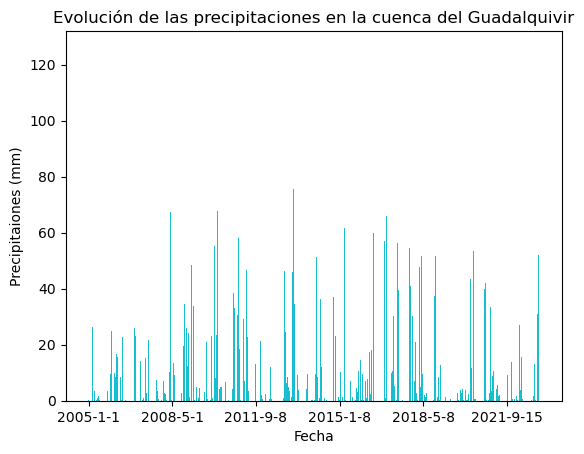

In [35]:

x = [i for i in range(len(pluvs))]
y = pluvs.values

plt.subplots()
plt.bar(x,y, color = "C9")
plt.title('Evolución de las precipitaciones en la cuenca del Guadalquivir')
plt.xlabel('Fecha')
plt.ylabel('Precipitaiones (mm)')

xticks = [ i*100 for i in range(0,11,2)]
xlabels = [ list( pluvs.keys() )[i] for i in xticks]
plt.xticks(xticks,xlabels)

### Hemos de crear un informe tabular con retardos de las variables explicativas

In [10]:
df = pd.concat([caps,pluvs], axis= 1)
df.columns = ["capacidad", "lluvias"]
df['t']= fecha_informes_date


#Agregamos las variables con retardo
fn=3 #numero de retardos
for t in range(fn):
    ti = f"t{t+1}" 
    lluvias_i =  f"lluvias{t+1}"
    capacidad_i =  f"capacidad{t+1}"
    df[ti] = df.t.shift(t+1) -pd.to_datetime('2005-01-01')
    df[ti] = df[ti].dt.days
    df[lluvias_i] = df.lluvias.shift(t+1)
    df[capacidad_i] = df.capacidad.shift(t+1) 
df = df.iloc[fn:,:] #eliminamos las primeras filas, pues se han quedado con valores NaN al introducir retardos
t_tags = [col for col in list( df.columns ) if col.startswith('t')]
lluvia_tags = [col for col in list( df.columns ) if col.startswith('lluvias')]
capacidad_tags = [col for col in list( df.columns ) if col.startswith('capacidad') and col != 'capacidad']
cols2 = t_tags + capacidad_tags +   lluvia_tags
cols2.append('capacidad')
df = df[cols2]
#transformamos los dtypes de las columns de tiempo y capacidad
tcap_tags = t_tags[1:] + capacidad_tags
df_dtypes = dict ( zip ( tcap_tags, ['int64']* len (tcap_tags) ) ) 
df = df.astype(df_dtypes) 
df=df.fillna(0)

print (df.dtypes)
df[0:10]



t             datetime64[ns]
t1                     int64
t2                     int64
t3                     int64
capacidad1             int64
                   ...      
lluvias              float64
lluvias1             float64
lluvias2             float64
lluvias3             float64
capacidad              int64
Length: 12, dtype: object


,t,t1,t2,t3,capacidad1,capacidad2,capacidad3,lluvias,lluvias1,lluvias2,lluvias3,capacidad
2005-1-22,2005-01-22,14,7,0,4874,4888,4893,0.0,0.0,0.0,0.2,4873
2005-1-31,2005-01-31,21,14,7,4873,4874,4888,0.0,0.0,0.0,0.0,4865
2005-2-1,2005-02-01,30,21,14,4865,4873,4874,4.7,0.0,0.0,0.0,4863
2005-2-8,2005-02-08,31,30,21,4863,4865,4873,2.1,4.7,0.0,0.0,4857
2005-2-15,2005-02-15,38,31,30,4857,4863,4865,0.0,2.1,4.7,0.0,4847
2005-2-22,2005-02-22,45,38,31,4847,4857,4863,26.4,0.0,2.1,4.7,4814
2005-2-28,2005-02-28,52,45,38,4814,4847,4857,26.4,26.4,0.0,2.1,4814
2005-3-1,2005-03-01,58,52,45,4814,4814,4847,33.3,26.4,26.4,0.0,4814
2005-3-8,2005-03-08,59,58,52,4814,4814,4814,3.4,33.3,26.4,26.4,4821
2005-3-15,2005-03-15,66,59,58,4821,4814,4814,0.0,3.4,33.3,26.4,4820


### Ahora debemos crear modelos de regresión que nos permitan predecir el nivel de capacidad de los embalses

Crearemos un modelo de regresión lineal

In [38]:
#Separamos la muestra de entrenamiento de la de testeo

train = df.head(int(len(df)*0.8))
test = df.drop(index=train.index)

len_df = len(df)
len_train = len(train) 

In [39]:
x_train_ll, x_test_ll = train[["lluvias",  "lluvias2","lluvias3"]],  test[["lluvias", "lluvias2","lluvias3"]]
y_train, y_test =  train["capacidad"], test["capacidad"]


mod_autoreg = AutoReg(endog = y_train, exog = x_train_ll, lags = 3).fit()

pred_autoreg = mod_autoreg.predict(start=0, end=len_df-1, exog_oos=x_test_ll)
sq_error_autoreg = mean_squared_error(y_test, pred_autoreg[len_train:len_df])
r2_autoreg = r2_score(y_test, pred_autoreg[len_train:len_df])
pred_autoreg

c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency

0               NaN
1               NaN
2               NaN
3       4834.556522
4       4824.956688
5       4883.203231
6       4843.477670
7       4877.088218
8       4810.689572
9       4813.279028
10      4815.119868
11      4779.273679
12      4762.005307
13      4778.101070
14      4723.298541
15      4681.642896
16      4605.451543
17      4532.221676
18      4548.118564
19      4490.514229
20      4338.060100
21      4286.123972
22      4073.099680
23      4090.281754
24      3990.899785
25      3867.696955
26      3744.149382
27      3633.203393
28      3656.553632
29      3537.843442
30      3410.106267
31      3280.452423
32      3168.314893
33      3192.563616
34      3063.287907
35      2956.880251
36      2863.479113
37      2664.906952
38      2724.430221
39      2633.843815
40      2657.203701
41      2651.305135
42      2617.969732
43      2619.525335
44      2779.274746
45      2653.712653
46      2666.433221
47      2642.835659
48      2644.723655
49      2644.327628


In [ ]:
mod_autoreg.pvalues

lluvias1    4.636481e-01
lluvias2    2.484877e-01
lluvias3    6.488502e-02
t1          6.516271e-42
t2          9.857502e-01
t3          8.732742e-42
dtype: float64

In [ ]:
print(f"El modelo ha arrojado un error cuadrático medio de {sq_error_autoreg}, con un coeficiente de determinación de {r2_autoreg} ")

El modelo ha arrojado un error cuadrático medio de 13107625.451445656, con un coeficiente de determinación de -26.819608593901684 


c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\Administrador\anaconda3\envs\python3113\Lib\site-packages\s

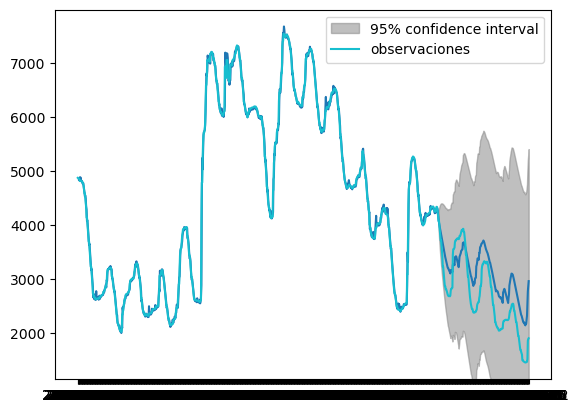

In [ ]:

mod_autoreg.plot_predict(start=0, end= len_df-1, exog_oos=x_test_ll)
plt.plot(df.index, df.capacidad, label = "observaciones", color = "C9")
plt.legend(bbox_to_anchor=(1,1))


In [ ]:


#separamos las variables regresoras de la variable objetivo
x_train_all, x_test_all = train.drop(columns= ["capacidad","t", "lluvias"]), test.drop(columns= ["capacidad","t", "lluvias"])
#normatlizamos las variables

#creamos  modelos de regresion linealLinearRegression
model1 = LinearRegression(fit_intercept=True).fit(x_train_all,y_train)
rfe = RFE( LinearRegression(fit_intercept=True), n_features_to_select= 3, step=1)
model2 = rfe.fit(x_train_all,y_train)
#generamos predicciones
pred1 = model1.predict(x_test_all)
pred2 = model2.predict(x_test_all)
#evaluamos el modelo predictivo
sq_error1 = mean_squared_error(y_test,pred1)
r2_1 = r2_score(y_test,pred1)
sq_error2 = mean_squared_error(y_test,pred2)
r2_2 = r2_score(y_test,pred2)


In [ ]:
model1.coef_

array([ 0.50590219, -0.89398313,  0.3876285 ,  1.18536318, -0.04296785,
       -0.14576295,  1.69836383,  0.0378274 ,  0.46363537])

In [ ]:

vars_rfe = model2.get_feature_names_out()


print(f"el modelo de regresión lineal con retardos obtuvo un error cuadrado medio de {sq_error1} y un coeficiente de determinación de {r2_1}")
print(f"el modelo de regresión lineal con RFE obtuvo un error cuadrado medio de {sq_error2} y un coeficiente de determinación de {r2_2}")
print(f"Las variables más representativas fueron {vars_rfe[0]}, {vars_rfe[1]}, {vars_rfe[2]} ")

el modelo de regresión lineal con retardos obtuvo un error cuadrado medio de 3894.9891672503727 y un coeficiente de determinación de 0.9917332796461283
el modelo de regresión lineal con RFE obtuvo un error cuadrado medio de 4455.843634096176 y un coeficiente de determinación de 0.990542922795943
Las variables más representativas fueron capacidad1, lluvias1, lluvias3 


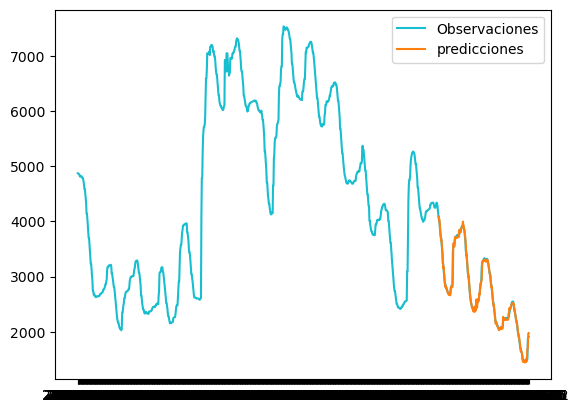

In [ ]:
plt.plot(df.index, df.capacidad, label = "Observaciones", color ="C9")
plt.plot(test.index, pred1, label = "predicciones", color ="C1")
plt.legend(bbox_to_anchor=(1,1))

### Vamos a importar datos relativos al consumo de agua

In [ ]:
#aprvechamiento del agua de las explotaciones agrícolas
#unidades: miles de metros cúbicos fuente: https://www.ine.es/jaxi/Tabla.htm?tpx=48823&L=0
ruta = "C:/Users/Administrador/Documents/data_science/databases/consumo_agua_cultivos_andalucia.xlsx"

with open(ruta):
    agcons = pd.read_excel(ruta) 


agcons

,,2018,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,TIPOS DE CULTIVOS,4175562,4086586,4216350,4204812,3763249,3658241,3592829,3757731,3667381,3536892,3712376,3776716,4074000,4475394,4611048,4506543,4415486,4391181
1,Herbáceos,1110999,1231579,1214352,1341852,1110638,1379030,1159042,848173,741784,490495,435416,721934,928669,946684,1627876,1274836,1340836,997486
2,Frutales,1009764,904452,957146,815845,774697,834676,726323,579121,570024,596093,564085,537028,627785,549852,644183,694000,590675,481004
3,Olivar y Viñedo,706692,765116,828576,951682,1036500,864515,1180724,1602274,1575598,1817248,1814254,1467884,1253616,1636619,556439,590185,575463,441654
4,Patatas y hortalizas,467054,421545,369204,254608,161500,150183,106790,158317,185442,226809,221208,315461,323298,328074,490746,294429,467629,1487211
5,Otros tipos de cultivos,881053,763894,847072,840825,679914,429837,419950,569846,594533,406247,677413,734409,940632,1014165,1291804,1653093,1440883,983826
6,TÉCNICAS DE RIEGO,4175562,4086586,4216350,4204812,3763249,3658241,3592829,3757731,3667381,3536892,3712376,3776716,4074000,4475394,4611048,4506543,4415486,4391181
7,Aspersión,350075,404696,354173,395252,354657,309192,367494,325531,397642,258715,334854,398595,572853,736032,835457,801353,683543,952298
8,Goteo,2923974,2752292,2824954,2804610,2621383,2634495,2346171,2484240,2284881,2526291,2513658,2451483,2190357,2355302,992185,820070,840935,702913
9,Gravedad,901513,929598,1037223,1004950,787209,714554,879164,947960,984858,751886,863864,926638,1310790,1384060,2783406,2885120,2891008,2735970


In [ ]:
index = list( agcons.columns)
index[0]= "indice"
agcons.columns = index

agcons = agcons.astype({"indice":"str"})
agcons.indice = agcons.indice.str.strip()

agcons.index = agcons.indice
agcons = agcons.iloc[:,1:]
agcons = agcons.T
agcons = agcons.sort_index()
agcons["Total"] = agcons["TIPOS DE CULTIVOS"]+agcons["TÉCNICAS DE RIEGO"]
agcons = agcons.drop(columns = ["TIPOS DE CULTIVOS", "TÉCNICAS DE RIEGO"])

agcons

indice,Herbáceos,Frutales,Olivar y Viñedo,Patatas y hortalizas,Otros tipos de cultivos,Aspersión,Goteo,Gravedad,Total
2000,997486,481004,441654,1487211,983826,952298,702913,2735970,8782362
2001,1340836,590675,575463,467629,1440883,683543,840935,2891008,8830972
2002,1274836,694000,590185,294429,1653093,801353,820070,2885120,9013086
2003,1627876,644183,556439,490746,1291804,835457,992185,2783406,9222096
2004,946684,549852,1636619,328074,1014165,736032,2355302,1384060,8950788
2005,928669,627785,1253616,323298,940632,572853,2190357,1310790,8148000
2006,721934,537028,1467884,315461,734409,398595,2451483,926638,7553432
2007,435416,564085,1814254,221208,677413,334854,2513658,863864,7424752
2008,490495,596093,1817248,226809,406247,258715,2526291,751886,7073784
2009,741784,570024,1575598,185442,594533,397642,2284881,984858,7334762


Text(0, 0.5, 'Miles de metros cúbicos')

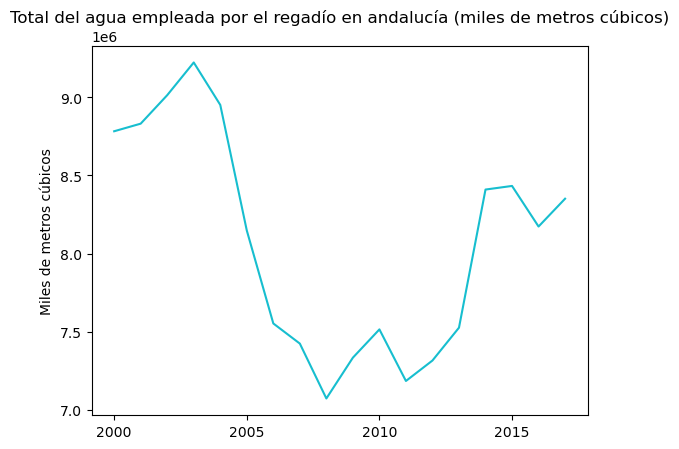

In [ ]:
plt.plot(agcons.index, agcons.Total, color ="C9")
plt.xticks(agcons.index[::5], agcons.index[::5])
plt.title("Total del agua empleada por el regadío en andalucía (miles de metros cúbicos)")
plt.ylabel("Miles de metros cúbicos")

In [ ]:
# https://www.ine.es/jaxi/Tabla.htm?path=/t01/p042/ccaa01/l0/&file=020106.px&L=0 
# # unidad:hectáreas

url = "https://servicios.ine.es/wstempus/js/ES/DATOS_TABLA//t01/p042/ccaa01/l0/020106.px/?tip=A"
r = requests.get(url)
print(r.status_code)
content = r.json()


content2 = [ i for i in content if "Ha" in i["Nombre"]]

olivar = [ i for i in content2 if "Olivar" in i["Nombre"]]
vinedo = [ i for i in content2 if "Viñedo" in i["Nombre"]]
frutal = [ i for i in content2 if "Frutales" in i["Nombre"]]
herb = [ i for i in content2 if "herbáceos" in i["Nombre"]]
otras = [ i for i in content2 if "Otras " in i["Nombre"]]

olivar_val= olivar[0]["Data"][0]["Valor"] 
vinedo_val = vinedo[0]["Data"][0]["Valor"]
frutal_val = frutal[0]["Data"][0]["Valor"] 
herb_val = herb[0]["Data"][0]["Valor"] 
otras_val = otras[0]["Data"][0]["Valor"] 

cencols = [ 'Cultivos herbáceos', 'Frutales',
        'Olivar', 'Viñedo', 'Otras tierras labradas']

cen1999 = pd.DataFrame([[herb_val,frutal_val,olivar_val, vinedo_val, otras_val]], columns = cencols)

cen1999



200


,Cultivos herbáceos,Frutales,Olivar,Viñedo,Otras tierras labradas
0,419837.0,84676.0,316466.0,3779.0,664.0


In [ ]:
content

[{'Nombre': 'Explot. con SAU, Todas las tierras labradas, Explotaciones',
  'Data': [{'Valor': 165913.0}]},
 {'Nombre': 'Explot. con SAU, Todas las tierras labradas, Ha.',
  'Data': [{'Valor': 825422.0}]},
 {'Nombre': 'Explot. con SAU, Cultivos herbáceos, Explotaciones',
  'Data': [{'Valor': 87153.0}]},
 {'Nombre': 'Explot. con SAU, Cultivos herbáceos, Ha.',
  'Data': [{'Valor': 419837.0}]},
 {'Nombre': 'Explot. con SAU, Frutales, Explotaciones',
  'Data': [{'Valor': 40959.0}]},
 {'Nombre': 'Explot. con SAU, Frutales, Ha.', 'Data': [{'Valor': 84676.0}]},
 {'Nombre': 'Explot. con SAU, Olivar, Explotaciones',
  'Data': [{'Valor': 69555.0}]},
 {'Nombre': 'Explot. con SAU, Olivar, Ha.', 'Data': [{'Valor': 316466.0}]},
 {'Nombre': 'Explot. con SAU, Viñedo, Explotaciones',
  'Data': [{'Valor': 3965.0}]},
 {'Nombre': 'Explot. con SAU, Viñedo, Ha.', 'Data': [{'Valor': 3779.0}]},
 {'Nombre': 'Explot. con SAU, Otras tierras labradas, Explotaciones',
  'Data': [{'Valor': 361.0}]},
 {'Nombre': 'Ex

In [ ]:

h = cen1999.values.reshape(len(cen1999.columns))

plt.bar(cen1999.columns, h, color ="C5")
plt.title("Empleo de la tierra cultivable en 1999 por Andalucía por cultivos")
plt.tight_layout()

NameError: name 'cen1999' is not defined

In [ ]:
#censo agrario 2009

#unidades: ha fuente  https://www.ine.es/jaxi/Tabla.htm?path=/t01/p042/a2009/ccaa01/l0/&file=0105.px&L=0
ruta = "C:/Users/Administrador/Documents/data_science/databases/censo_agrario_2009.xls"

with open(ruta):
    cen2009 = pd.read_excel(ruta) 

cen2009

,,Todas las tierras labradas,Cultivos herbáceos,Frutales,Olivar,Viñedo,Otras tierras labradas
0,Explotaciones con SAU,792633,322620,105650,359366,2837,2160


In [ ]:
cen2009.index = [2009]
cen2009 = cen2009.iloc[:,2:]

cen2009

,Cultivos herbáceos,Frutales,Olivar,Viñedo,Otras tierras labradas
2009,322620,105650,359366,2837,2160


In [ ]:
#https://www.ine.es/jaxi/Tabla.htm?path=/t01/p042/a2009/ccaa01/l0/&file=0105.px&L=0
## unidades: hectáreas

url = "https://servicios.ine.es/wstempus/js/ES/DATOS_TABLA//t01/p042/a2009/ccaa01/l0/0105.px?tip=A"
r = requests.get(url)
print(r.status_code)
content = r.json()


content2 = [ i for i in content if "Ha" in i["Nombre"]]

olivar = [ i for i in content2 if "Olivar" in i["Nombre"]]
vinedo = [ i for i in content2 if "Viñedo" in i["Nombre"]]
frutal = [ i for i in content2 if "Frutales" in i["Nombre"]]
herb = [ i for i in content2 if "herbáceos" in i["Nombre"]]
otras = [ i for i in content2 if "Otras " in i["Nombre"]]

olivar_val= olivar[0]["Data"][0]["Valor"] 
vinedo_val = vinedo[0]["Data"][0]["Valor"]
frutal_val = frutal[0]["Data"][0]["Valor"] 
herb_val = herb[0]["Data"][0]["Valor"] 
otras_val = otras[0]["Data"][0]["Valor"] 

cencols = [ 'Cultivos herbáceos', 'Frutales',
        'Olivar', 'Viñedo', 'Otras tierras labradas']

cen2009 = pd.DataFrame([[herb_val,frutal_val,olivar_val, vinedo_val, otras_val]], columns = cencols)

cen2009


200


,Cultivos herbáceos,Frutales,Olivar,Viñedo,Otras tierras labradas
0,322620.0,105650.0,359366.0,2837.0,2160.0


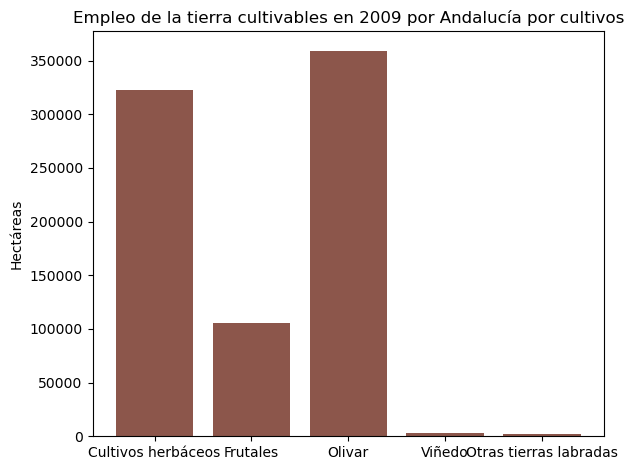

In [ ]:
h = cen2009.values.reshape(len(cen2009.columns))
plt.bar(cen2009.columns, h, color ="C5")
plt.title("Empleo de la tierra cultivables en 2009 por Andalucía por cultivos")
plt.ylabel("Hectáreas")
plt.tight_layout()

In [ ]:
#superficie regada según el método 1999 
#unidades: ha fuenta: https://www.ine.es/jaxi/Tabla.htm?path=/t01/p042/ccaa01/l0/&file=010802.px&L=0
ruta = "C:/Users/Administrador/Documents/data_science/databases/tipos_riego_1999.xls"

with open(ruta):
    tip1999 = pd.read_excel(ruta) 

tip1999

,,Aspersión,Localizado,Gravedad,Otros métodos
0,Explotaciones con tierras,162108,412306,246265,11872


In [ ]:
tip1999.index = [1999]
tip1999 = tip1999.iloc[:,2:]

tip1999

,Localizado,Gravedad,Otros métodos
1999,412306,246265,11872


In [ ]:
tip1999.values.reshape(3)

array([412306, 246265,  11872], dtype=int64)

Text(0.5, 1.0, 'Distribución de las tierras de cultivo en Andalucía en 1999 por tipo de riego')

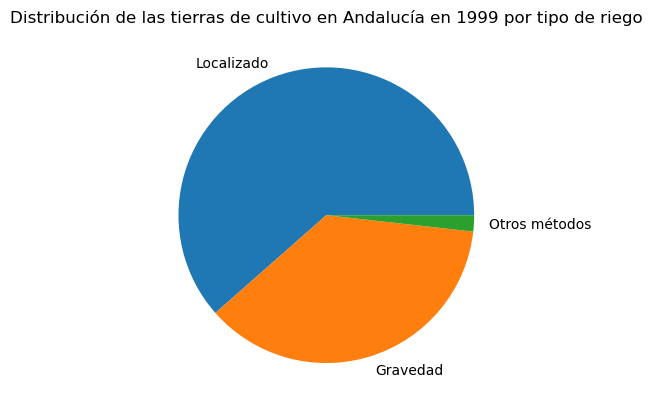

In [ ]:
z = tip1999.values.reshape(3)

plt.pie(z,labels=tip1999.columns)
plt.title("Distribución de las tierras de cultivo en Andalucía en 1999 por tipo de riego")


In [ ]:
#superficie regada según el método 2009 
#unidades: ha fuenta: https://www.ine.es/jaxi/Tabla.htm?path=/t01/p042/ccaa01/l0/&file=010802.px&L=0
ruta = "C:/Users/Administrador/Documents/data_science/databases/tipos_riego_2009.xls"

with open(ruta):
    tip2009 = pd.read_excel(ruta) 

tip2009

,,Total,Aspersión,Localizado,Gravedad
0,Explotaciones con SAU,800620,105784,570021,124816


In [ ]:
tip2009.index = [2009]
tip2009 = tip2009.iloc[:,2:]
tip2009

,Aspersión,Localizado,Gravedad
2009,105784,570021,124816


Text(0.5, 1.0, 'Distribución de las tierras de cultivo en Andalucía en 2009 por tipo de riego')

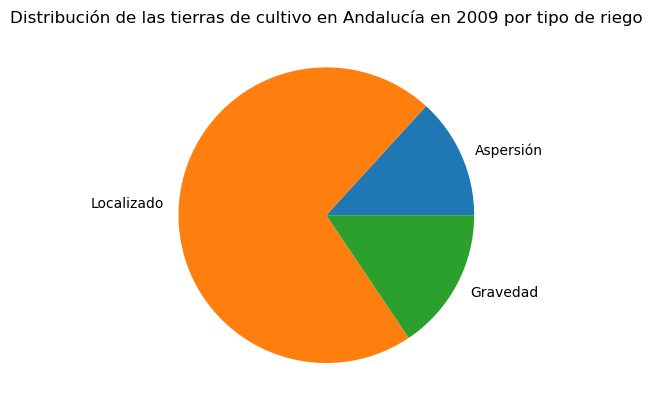

In [ ]:
z = tip2009.values.reshape(3)

plt.pie(z,labels=tip2009.columns)
plt.title("Distribución de las tierras de cultivo en Andalucía en 2009 por tipo de riego")

In [ ]:
#población total en andalucía
#unidades: nº personas fuente: https://www.ine.es/jaxiT3/Tabla.htm?t=56940&L=0

ruta = "C:/Users/Administrador/Documents/data_science/databases/poblacion_andalucia.xls"

with open(ruta):
    pob = pd.read_excel(ruta) 

pob

,,1 de enero de 2023,1 de octubre de 2022,1 de julio de 2022,1 de abril de 2022,1 de enero de 2022,1 de octubre de 2021,1 de julio de 2021,1 de abril de 2021,1 de enero de 2021,1 de octubre de 2020,1 de julio de 2020,1 de abril de 2020,1 de enero de 2020,1 de octubre de 2019,1 de julio de 2019,1 de abril de 2019,1 de enero de 2019,1 de octubre de 2018,1 de julio de 2018,1 de abril de 2018,1 de enero de 2018,1 de octubre de 2017,1 de julio de 2017,1 de abril de 2017,1 de enero de 2017,1 de octubre de 2016,1 de julio de 2016,1 de abril de 2016,1 de enero de 2016,1 de octubre de 2015,1 de julio de 2015,1 de abril de 2015,1 de enero de 2015,1 de octubre de 2014,1 de julio de 2014,1 de abril de 2014,1 de enero de 2014,1 de octubre de 2013,1 de julio de 2013,1 de abril de 2013,1 de enero de 2013,1 de octubre de 2012,1 de julio de 2012,1 de abril de 2012,1 de enero de 2012,1 de octubre de 2011,1 de julio de 2011,1 de abril de 2011,1 de enero de 2011,1 de octubre de 2010,1 de julio de 2010,1 de abril de 2010,1 de enero de 2010,1 de octubre de 2009,1 de julio de 2009,1 de abril de 2009,1 de enero de 2009,1 de octubre de 2008,1 de julio de 2008,1 de abril de 2008,1 de enero de 2008,1 de octubre de 2007,1 de julio de 2007,1 de abril de 2007,1 de enero de 2007,1 de octubre de 2006,1 de julio de 2006,1 de abril de 2006,1 de enero de 2006,1 de octubre de 2005,1 de julio de 2005,1 de abril de 2005,1 de enero de 2005,1 de octubre de 2004,1 de julio de 2004,1 de abril de 2004,1 de enero de 2004,1 de octubre de 2003,1 de julio de 2003,1 de abril de 2003,1 de enero de 2003,1 de octubre de 2002,1 de julio de 2002,1 de abril de 2002,1 de enero de 2002,1 de octubre de 2001,1 de julio de 2001,1 de abril de 2001,1 de enero de 2001,1 de octubre de 2000,1 de julio de 2000,1 de abril de 2000,1 de enero de 2000,1 de octubre de 1999,1 de julio de 1999,1 de abril de 1999,1 de enero de 1999,1 de octubre de 1998,1 de julio de 1998,1 de abril de 1998,1 de enero de 1998,1 de octubre de 1997,1 de julio de 1997,1 de abril de 1997,1 de enero de 1997,1 de octubre de 1996,1 de julio de 1996,1 de abril de 1996,1 de enero de 1996,1 de octubre de 1995,1 de julio de 1995,1 de abril de 1995,1 de enero de 1995,1 de octubre de 1994,1 de julio de 1994,1 de abril de 1994,1 de enero de 1994,1 de octubre de 1993,1 de julio de 1993,1 de abril de 1993,1 de enero de 1993,1 de octubre de 1992,1 de julio de 1992,1 de abril de 1992,1 de enero de 1992,1 de octubre de 1991,1 de julio de 1991,1 de abril de 1991,1 de enero de 1991,1 de octubre de 1990,1 de julio de 1990,1 de abril de 1990,1 de enero de 1990,1 de octubre de 1989,1 de julio de 1989,1 de abril de 1989,1 de enero de 1989,1 de octubre de 1988,1 de julio de 1988,1 de abril de 1988,1 de enero de 1988,1 de octubre de 1987,1 de julio de 1987,1 de abril de 1987,1 de enero de 1987,1 de octubre de 1986,1 de julio de 1986,1 de abril de 1986,1 de enero de 1986,1 de octubre de 1985,1 de julio de 1985,1 de abril de 1985,1 de enero de 1985,1 de octubre de 1984,1 de julio de 1984,1 de abril de 1984,1 de enero de 1984,1 de octubre de 1983,1 de julio de 1983,1 de abril de 1983,1 de enero de 1983,1 de octubre de 1982,1 de julio de 1982,1 de abril de 1982,1 de enero de 1982,1 de octubre de 1981,1 de julio de 1981,1 de abril de 1981,1 de enero de 1981,1 de octubre de 1980,1 de julio de 1980,1 de abril de 1980,1 de enero de 1980,1 de octubre de 1979,1 de julio de 1979,1 de abril de 1979,1 de enero de 1979,1 de octubre de 1978,1 de julio de 1978,1 de abril de 1978,1 de enero de 1978,1 de octubre de 1977,1 de julio de 1977,1 de abril de 1977,1 de enero de 1977,1 de octubre de 1976,1 de julio de 1976,1 de abril de 1976,1 de enero de 1976,1 de octubre de 1975,1 de julio de 1975,1 de abril de 1975,1 de enero de 1975,1 de octubre de 1974,1 de julio de 1974,1 de abril de 1974,1 de enero de 1974,1 de octubre de 1973,1 de julio de 1973,1 de abril de 1973,1 de enero de 1973,1 de octubre de 1972,1 de julio de 1972,1 de abril de 1972,1 de enero de 1972,1

In [ ]:
pob2 = pob.T
pob2[-1:0:-1]
pob2.columns =  ["poblacion"]

pob = pob.filter(regex="1 de enero")
cols = [col[-5:] for col in pob.columns]
pob.columns = cols
pob = pob.T 
pob.columns = ["poblacion"]
pob = pob.sort_index()
pob.index = [ind.strip() for ind in pob.index]
pob

,poblacion
1971,5990874
1972,6038130
1973,6088717
1974,6135074
1975,6182072
1976,6226573
1977,6271866
1978,6317098
1979,6358248
1980,6396876


([<matplotlib.axis.XTick at 0x1d473e9e650>,
 [Text(0.0, 0, '1971'),
  Text(5.0, 0, '1976'),
  Text(10.0, 0, '1981'),
  Text(15.0, 0, '1986'),
  Text(20.0, 0, '1991'),
  Text(25.0, 0, '1996'),
  Text(30.0, 0, '2001'),
  Text(35.0, 0, '2006'),
  Text(40.0, 0, '2011'),
  Text(45.0, 0, '2016'),
  Text(50.0, 0, '2021')])

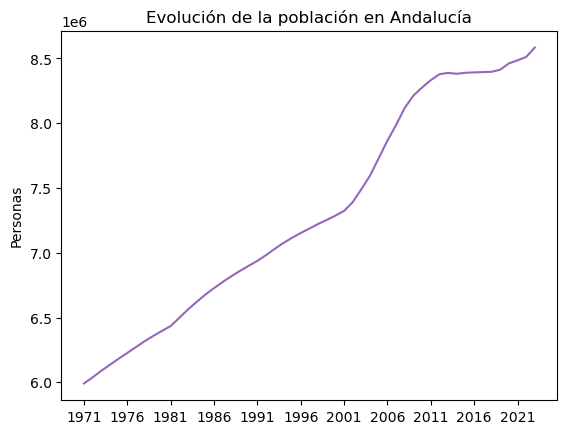

In [ ]:
plt.plot(pob.index, pob, color ="C4")
plt.title("Evolución de la población en Andalucía")
plt.ylabel("Personas")
plt.xticks(pob.index[::5],pob.index[::5])

In [ ]:
#agua suministrada a la red pública 
#unidades : miles de m^3 fuente: https://www.ine.es/jaxi/Tabla.htm?tpx=53447&L=0

ruta = "C:/Users/Administrador/Documents/data_science/databases/agua_red_publica.xls"

with open(ruta):
    redp = pd.read_excel(ruta) 

redp

,,2020,2018,2016,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,Volumen de agua suministrada a la red de a...,792785,747296,759283,774668,758263,792450,793125,802301,867854,861264,879369,912082,1021494,979756,935912,878851,858157,820608


In [ ]:
redp = redp.T
redp = redp.sort_index()
redp.columns = ["agua" ]
redp = redp.iloc[1:,:]

redp

,agua
2000,820608
2001,858157
2002,878851
2003,935912
2004,979756
2005,1021494
2006,912082
2007,879369
2008,861264
2009,867854


([<matplotlib.axis.XTick at 0x1d473c57750>,
 [Text(0.0, 0, '2000'),
  Text(5.0, 0, '2005'),
  Text(10.0, 0, '2010'),
  Text(15.0, 0, '2016')])

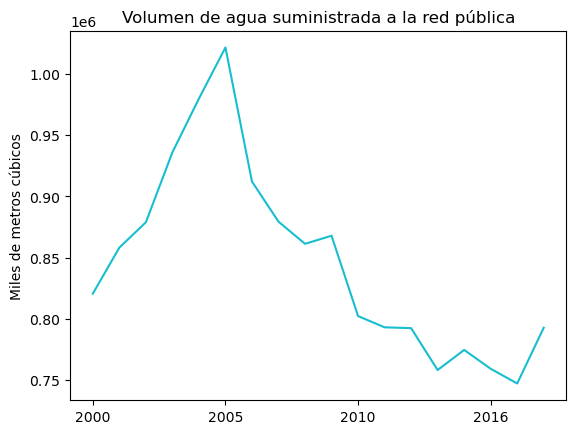

In [ ]:
plt.plot(redp.index, redp, color ="C9")
plt.title("Volumen de agua suministrada a la red pública")
plt.ylabel("Miles de metros cúbicos")
plt.xticks(redp.index[::5],redp.index[::5])

### Damos tratamiento a los datos de consumo

Comprobamos la evolución de los consumos por hectárea de las diferentes tierras

In [ ]:
print(agcons.loc["2000","Herbáceos"]/ cen1999["Cultivos herbáceos"])
print( agcons.loc["2009","Herbáceos"] /cen2009["Cultivos herbáceos"] )

print("---------------------------------------------------")

print   (agcons.loc["2000","Frutales"]/ cen1999["Frutales"]  ) 
print  (agcons.loc["2009","Frutales"]/ cen2009["Frutales"]  ) 

print("---------------------------------------------------")


print(agcons.loc["2000","Olivar y Viñedo"]/ (cen1999["Olivar"] + cen1999["Viñedo"])   ) 
print(agcons.loc["2009","Olivar y Viñedo"]/ (cen2009["Olivar"] + cen2009["Viñedo"])   ) 

print("---------------------------------------------------")


print   (agcons.loc["2000","Goteo"]/ tip1999["Localizado"]  ) 
print  (agcons.loc["2009","Goteo"]/ tip2009["Localizado"]  ) 


print("---------------------------------------------------")

print   (agcons.loc["2000","Gravedad"]/ tip1999["Gravedad"]  ) 
print  (agcons.loc["2009","Gravedad"]/ tip2009["Gravedad"]  ) 


0    2.375889
Name: Cultivos herbáceos, dtype: float64
0    2.29925
Name: Cultivos herbáceos, dtype: float64
---------------------------------------------------
0    5.680523
Name: Frutales, dtype: float64
0    5.3954
Name: Frutales, dtype: float64
---------------------------------------------------
0    1.379113
dtype: float64
0    4.350041
dtype: float64
---------------------------------------------------
1999    1.704833
Name: Localizado, dtype: float64
2009    4.008415
Name: Localizado, dtype: float64
---------------------------------------------------
1999    11.109861
Name: Gravedad, dtype: float64
2009    7.890479
Name: Gravedad, dtype: float64


Creamos un modelo predictivo de la capacidad de los embalses en base a la población y el consumo urbano de agua

In [ ]:
pob.index = [int(fecha) for fecha in pob.index]
redp.index = [int(ind) for ind in redp.index]
df["year"] = [fecha.year for fecha in df.t]
ycap = df.groupby("year").mean()["capacidad"]
redcap =  pd.concat([redp, ycap,pob], axis=1)
redcap = redcap.dropna()
redcap

,agua,capacidad,poblacion
2005,1021494,3659.666667,7730705
2006,912082,2675.833333,7865775
2007,879369,2749.650000,7986597
2008,861264,2538.783333,8118575
2009,867854,3212.033333,8212986
2010,802301,6526.900000,8276017
2011,793125,6681.733333,8332087
2012,792450,5397.733333,8377809
2013,758263,6776.400000,8387986
2014,774668,6496.783333,8381239


In [ ]:
redcap.corr()

,agua,capacidad,poblacion
agua,1.000000,-0.564347,-0.949305
capacidad,-0.564347,1.000000,0.544721
poblacion,-0.949305,0.544721,1.000000


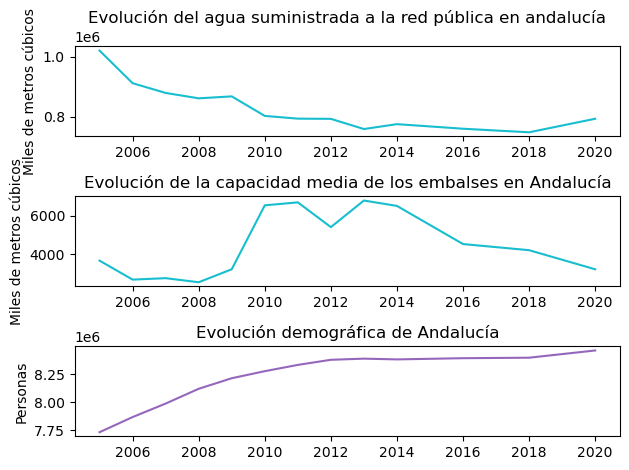

In [ ]:


plt.subplot(311)
plt.plot(redcap.index, redcap.agua, color ="C9")
plt.title("Evolución del agua suministrada a la red pública en andalucía")
plt.ylabel("Miles de metros cúbicos")

plt.subplot(312)
plt.plot(redcap.index, redcap.capacidad, color ="C9")
plt.title("Evolución de la capacidad media de los embalses en Andalucía")
plt.ylabel("Miles de metros cúbicos")


plt.subplot(313)
plt.plot(redcap.index, redcap.poblacion, color ="C4")
plt.title("Evolución demográfica de Andalucía")
plt.ylabel("Personas")

plt.tight_layout()



In [ ]:
pob.index = [int(fecha) for fecha in pob.index]
redp.index = [int(ind) for ind in redp.index]
df["year"] = [fecha.year for fecha in df.t]
ycap = df.groupby("year").mean()["capacidad"]
redcap =  pd.concat([redp, ycap,pob], axis=1)
redcap = redcap.dropna()
redcap

,agua,capacidad,poblacion
2005,1021494,3659.666667,7730705
2006,912082,2675.833333,7865775
2007,879369,2749.650000,7986597
2008,861264,2538.783333,8118575
2009,867854,3212.033333,8212986
2010,802301,6526.900000,8276017
2011,793125,6681.733333,8332087
2012,792450,5397.733333,8377809
2013,758263,6776.400000,8387986
2014,774668,6496.783333,8381239


In [ ]:
for column in redcap.columns:
    for i in range(3):
        redcap[f"{column}_{i+1}"] = redcap[f"{column}"].shift(i+1)



redcap

,agua,capacidad,poblacion,agua_1,agua_2,agua_3,capacidad_1,capacidad_2,capacidad_3,poblacion_1,poblacion_2,poblacion_3
2005,1021494,3659.666667,7730705,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2006,912082,2675.833333,7865775,1021494,None,None,3659.666667,NaN,NaN,7730705.0,NaN,NaN
2007,879369,2749.650000,7986597,912082,1021494,None,2675.833333,3659.666667,NaN,7865775.0,7730705.0,NaN
2008,861264,2538.783333,8118575,879369,912082,1021494,2749.650000,2675.833333,3659.666667,7986597.0,7865775.0,7730705.0
2009,867854,3212.033333,8212986,861264,879369,912082,2538.783333,2749.650000,2675.833333,8118575.0,7986597.0,7865775.0
2010,802301,6526.900000,8276017,867854,861264,879369,3212.033333,2538.783333,2749.650000,8212986.0,8118575.0,7986597.0
2011,793125,6681.733333,8332087,802301,867854,861264,6526.900000,3212.033333,2538.783333,8276017.0,8212986.0,8118575.0
2012,792450,5397.733333,8377809,793125,802301,867854,6681.733333,6526.900000,3212.033333,8332087.0,8276017.0,8212986.0
2013,758263,6776.400000,8387986,792450,793125,802301,5397.733333,6681.733333,6526.900000,8377809.0,8332087.0,8276017.0
2014,774668,6496.783333,8381239,758263,792450,793125,6776.400000,5397.733333,6681.733333,8387986.0,8377809.0,8332087.0


In [ ]:
x_redcap  = redcap.filter(regex="^(?!.*capacidad).*$")
y_redcap = redcap["capacidad"]

x_redcap = x_redcap.dropna()
y_redcap = y_redcap.loc["2008":]


print(x_redcap)
print("\n")
print(y_redcap)


        agua  poblacion  agua_1  agua_2   agua_3  poblacion_1  poblacion_2  \
2008  861264    8118575  879369  912082  1021494    7986597.0    7865775.0   
2009  867854    8212986  861264  879369   912082    8118575.0    7986597.0   
2010  802301    8276017  867854  861264   879369    8212986.0    8118575.0   
2011  793125    8332087  802301  867854   861264    8276017.0    8212986.0   
2012  792450    8377809  793125  802301   867854    8332087.0    8276017.0   
2013  758263    8387986  792450  793125   802301    8377809.0    8332087.0   
2014  774668    8381239  758263  792450   793125    8387986.0    8377809.0   
2016  759283    8392046  774668  758263   792450    8381239.0    8387986.0   
2018  747296    8396464  759283  774668   758263    8392046.0    8381239.0   
2020  792785    8461039  747296  759283   774668    8396464.0    8392046.0   

      poblacion_3  
2008    7730705.0  
2009    7865775.0  
2010    7986597.0  
2011    8118575.0  
2012    8212986.0  
2013    8276017.0  
2

In [ ]:
mod_redcap = LinearRegression().fit(x_redcap, y_redcap)

In [ ]:
pred_redcap = mod_redcap.predict(x_redcap)



In [ ]:
sq_error_redcap = mean_squared_error(pred_redcap, y_redcap)
r2_redcap = r2_score(pred_redcap, y_redcap)

print(f" El error cuadrático medio fue de {sq_error_redcap}, obteniendo un coeficiente de determinación del {r2_redcap}")

 El error cuadrático medio fue de 3661.8996515688864, obteniendo un coeficiente de determinación del 0.9984732940738918


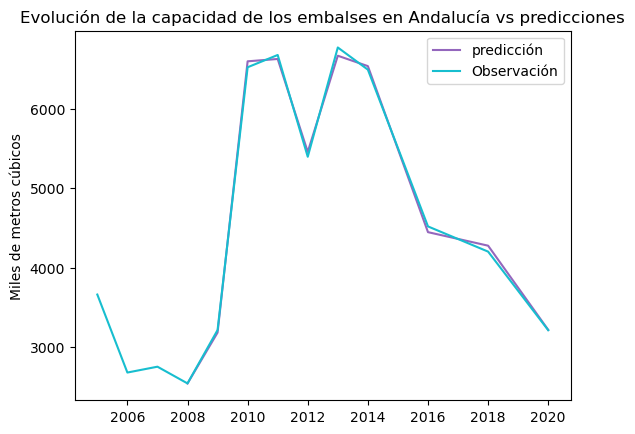

In [ ]:
plt.plot(x_redcap.index, pred_redcap,label ="predicción", color = "C4" )

plt.plot(redcap.index, redcap.capacidad,label ="Observación", color = "C9" )
plt.title("Evolución de la capacidad de los embalses en Andalucía vs predicciones")
plt.ylabel("Miles de metros cúbicos")
plt.legend(bbox_to_anchor = (1,1))

In [41]:
geo = gp.read_file("C:/Users/Administrador/Documents/data_science/databases/Area.shp")

In [44]:
geo

,NOMBRE,COD_AREA,geometry
0,Los Pedroches,350,"POLYGON ((311935.188 4283258, 311936 4283318, ..."
1,Segura,619,"POLYGON ((519319.594 4262578, 519335.5 4262626..."
2,El Condado,613,"POLYGON ((510550.875 4256279.5, 510179 4256180..."
3,Sierra Morena,615,"POLYGON ((460531.188 4250508, 460643 4250249, ..."
4,Cuenca del Segura,650,"POLYGON ((547925 4230420, 547935.812 4230361, ..."
...,...,...,...
163,Z.R. Barbate,220,"POLYGON ((238848.781 4023045.5, 238953.719 402..."
164,Riegos del Barbate,221,"POLYGON ((265241 4022544, 265001 4022127, 2644..."
165,Z.R. Guadarranque,250,"POLYGON ((276073.906 4006647.25, 276100.281 40..."
166,Los Humosos,833,"POLYGON ((321067.954 4144743.374, 320760.783 4..."


Text(0.5, 1.0, 'Unidades de agregación del inventario de regadíos. Andalucía 2009')

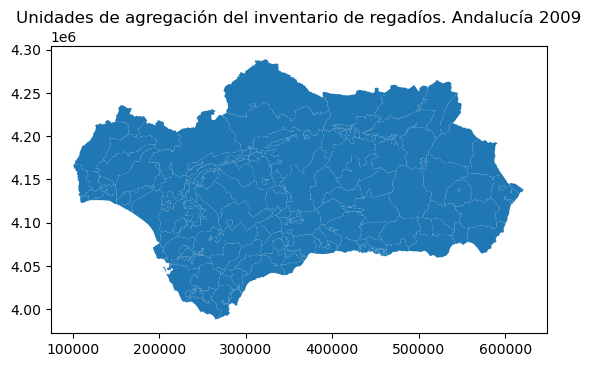

In [48]:
geo.plot()
plt.title("Unidades de agregación del inventario de regadíos. Andalucía 2009")